In [1]:
import pandas as pd
import numpy as np
import warnings

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, make_scorer, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from mlxtend.classifier import StackingClassifier

from matplotlib import pyplot as plt
%matplotlib inline

# Visiology test task
Appendicitis type classification

In [2]:
data = pd.read_csv("./data/03 - Appendicitis.csv", index_col='Unnamed: 0')

In [3]:
data.shape

(103, 13)

In [4]:
data.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,Type
1,1,0,0,1,1,1,0,1,1,1,0,1,1
2,1,0,1,1,0,1,0,1,1,1,0,1,1
3,1,0,0,1,1,1,0,0,1,1,1,1,1


In [5]:
data.isnull().sum()

V1      0
V2      0
V3      0
V4      0
V5      0
V6      0
V7      0
V8      0
V9      0
V10     0
V11     0
V12     0
Type    0
dtype: int64

No missing values

In [6]:
with open("./data/03 - Appendicitis.txt", 'r', encoding='cp1251') as f:
    desc_text = f.readlines()

desc = {a: b for (a, b) in [row.split('\t') for row in [row.split('\n')[0] for row in desc_text]]}
desc

{'Type': 'Тип аппендицита (0 - отсутствует, 1 - гангренозный, 2 - флегмонозный, 3 - катаральный)',
 'V1': 'Выраженные боли в правой подвздошной области',
 'V10': 'Симптом Щеткина-Блюмберга выражен',
 'V11': 'Симптом Ровзинга выражен',
 'V12': 'Защитное мышечное напряжение выражено',
 'V2': 'Боли более 48 часов',
 'V3': 'Боли более 24 часов',
 'V4': 'Боли более 12 часов',
 'V5': 'Частота пульса менее 80 уд/мин',
 'V6': 'Частота пульса менее 100 уд/мин',
 'V7': 'Лейкоциты крови ниже 8 тыс. ед.',
 'V8': 'Лейкоциты крови ниже 14 тыс. ед.',
 'V9': 'Язык  обложен'}

In [7]:
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,Type
count,103.000000,103.00000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,0.611650,0.15534,0.339806,0.699029,0.669903,0.961165,0.291262,0.796117,0.650485,0.582524,0.601942,0.543689,1.514563
std,0.489758,0.36400,0.475959,0.460923,0.472547,0.194146,0.456566,0.404853,0.479148,0.495554,0.491891,0.500523,1.110238
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.500000
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [8]:
for col in data.columns:
    print(col, desc[col], '\n', data[col].value_counts(), '\n')

V1 Выраженные боли в правой подвздошной области 
 1    63
0    40
Name: V1, dtype: int64 

V2 Боли более 48 часов 
 0    87
1    16
Name: V2, dtype: int64 

V3 Боли более 24 часов 
 0    68
1    35
Name: V3, dtype: int64 

V4 Боли более 12 часов 
 1    72
0    31
Name: V4, dtype: int64 

V5 Частота пульса менее 80 уд/мин 
 1    69
0    34
Name: V5, dtype: int64 

V6 Частота пульса менее 100 уд/мин 
 1    99
0     4
Name: V6, dtype: int64 

V7 Лейкоциты крови ниже 8 тыс. ед. 
 0    73
1    30
Name: V7, dtype: int64 

V8 Лейкоциты крови ниже 14 тыс. ед. 
 1    82
0    21
Name: V8, dtype: int64 

V9 Язык  обложен 
 1    67
0    36
Name: V9, dtype: int64 

V10 Симптом Щеткина-Блюмберга выражен 
 1    60
0    43
Name: V10, dtype: int64 

V11 Симптом Ровзинга выражен 
 1    62
0    41
Name: V11, dtype: int64 

V12 Защитное мышечное напряжение выражено 
 1    56
0    47
Name: V12, dtype: int64 

Type Тип аппендицита (0 - отсутствует, 1 - гангренозный, 2 - флегмонозный, 3 - катаральный) 
 1   

## Correlation

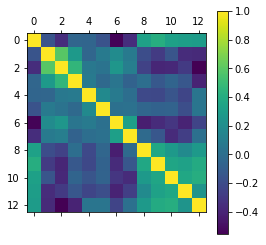

In [9]:
plt.matshow(data.corr())
plt.colorbar();

In [10]:
def find_correlation(data, threshold=0.9):
    """
    Given a numeric pd.DataFrame, this will find highly correlated features,
    and return a list of features to remove.
    
    Code from here:
    https://gist.github.com/Swarchal/e29a3a1113403710b6850590641f046c
    
    Parameters
    -----------
    data : pandas DataFrame
        DataFrame
    threshold : float
        correlation threshold, will remove one of pairs of features with a
        correlation greater than this value
    Returns
    --------
    select_flat : list
        listof column names to be removed
    """
    corr_mat = data.corr()
    corr_mat.loc[:, :] = np.tril(corr_mat, k=-1)
    already_in = set()
    result = []
    for col in corr_mat:
        perfect_corr = corr_mat[col][corr_mat[col] > threshold].index.tolist()
        if perfect_corr and col not in already_in:
            already_in.update(set(perfect_corr))
            perfect_corr.append(col)
            result.append(perfect_corr)
    select_nested = [f[1:] for f in result]
    select_flat = [i for j in select_nested for i in j]
    return select_flat

In [11]:
find_correlation(data)

[]

No highly correlated features.

## Feature importances

In [12]:
def test_clf(clf, X, y):
    """
    Test the classifier.
    Recall is chosen to minimize the error
    when finding ill people.
    """
    with warnings.catch_warnings(): 
        warnings.simplefilter("ignore")
        recall_scorer = make_scorer(recall_score, average='macro')
        recall_res = cross_val_score(clf, X, y, scoring=recall_scorer, cv=10)
        f1_scorer = make_scorer(f1_score, average='macro')
        f1_res = cross_val_score(clf, X, y, scoring=f1_scorer, cv=10)
    print("Recall: {} +/- {}".format(np.mean(recall_res), np.std(recall_res)))
    print("F1: {} +/- {}".format(np.mean(f1_res), np.std(f1_res)))

In [13]:
X, y = data.drop('Type', axis=1), data['Type']

In [14]:
rf = RandomForestClassifier()
test_clf(rf, X, y)

Recall: 0.6333333333333333 +/- 0.14409680388158821
F1: 0.5847619047619048 +/- 0.11199913700266803


In [15]:
rf.fit(X, y)
importances = sorted(list(zip(rf.feature_importances_, X.columns)), key=lambda x: x[0], reverse=True)
importances

[(0.14870173311275234, 'V12'),
 (0.12937279623960357, 'V10'),
 (0.12491862735483852, 'V4'),
 (0.11820626674460208, 'V11'),
 (0.08854644680083856, 'V5'),
 (0.08643352757847376, 'V1'),
 (0.07331682761078939, 'V3'),
 (0.07032536569252171, 'V9'),
 (0.06403072222985472, 'V8'),
 (0.049847872858259576, 'V7'),
 (0.02780283687244863, 'V2'),
 (0.01849697690501719, 'V6')]

In [16]:
for i in range(1, len(importances) + 1):
    cols = list(map(lambda x: x[1], importances[:i]))
    X_cur = X[cols]
    clf = RandomForestClassifier()
    test_clf(clf, X_cur, y)
    print(cols)
    print()

Recall: 0.475 +/- 0.03818813079129868
F1: 0.320719696969697 +/- 0.02842393397029661
['V12']

Recall: 0.5791666666666666 +/- 0.08630131323836658
F1: 0.5222619047619047 +/- 0.08340694028121898
['V12', 'V10']

Recall: 0.6791666666666666 +/- 0.07916666666666668
F1: 0.6229761904761905 +/- 0.09393008025826581
['V12', 'V10', 'V4']

Recall: 0.6083333333333333 +/- 0.10736748938937606
F1: 0.5945238095238097 +/- 0.08250987709719428
['V12', 'V10', 'V4', 'V11']

Recall: 0.6583333333333333 +/- 0.109924216318941
F1: 0.6461904761904762 +/- 0.0674881361876078
['V12', 'V10', 'V4', 'V11', 'V5']

Recall: 0.6875 +/- 0.09547032697824669
F1: 0.6668452380952381 +/- 0.09153207884078728
['V12', 'V10', 'V4', 'V11', 'V5', 'V1']

Recall: 0.6541666666666666 +/- 0.08133008873309641
F1: 0.6419444444444443 +/- 0.10112654376257282
['V12', 'V10', 'V4', 'V11', 'V5', 'V1', 'V3']

Recall: 0.6416666666666666 +/- 0.10897247358851686
F1: 0.6136309523809524 +/- 0.10522100768945179
['V12', 'V10', 'V4', 'V11', 'V5', 'V1', 'V3', 

## Different classifiers

Random Forest

In [17]:
rf = RandomForestClassifier(n_estimators=10)
test_clf(rf, X, y)

Recall: 0.6458333333333333 +/- 0.12672421938121292
F1: 0.6235515873015872 +/- 0.12132994263253366


Gradient Boosting

In [18]:
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50)
test_clf(gb, X, y)

Recall: 0.6041666666666667 +/- 0.10248644896874036
F1: 0.5658333333333332 +/- 0.08289561914522013


In [19]:
cat = CatBoostClassifier(verbose=False)
test_clf(cat, X, y)

Recall: 0.42333333333333334 +/- 0.4158124577258358
F1: 0.41307189542483663 +/- 0.4155629364438572


Logistic Regression

In [20]:
lr = LogisticRegression()
test_clf(lr, X, y)

Recall: 0.65 +/- 0.08579691784155835
F1: 0.6179166666666666 +/- 0.10822157042377763


Naïve Bayes

In [21]:
mnb = MultinomialNB()
test_clf(mnb, X, y)

Recall: 0.6708333333333333 +/- 0.10937003957005574
F1: 0.6710119047619048 +/- 0.10811793408157605


In [22]:
gnb = GaussianNB()
test_clf(gnb, X, y)

Recall: 0.5208333333333333 +/- 0.06521864934374387
F1: 0.4560119047619048 +/- 0.07477216433243669


kNN

In [23]:
knn = KNeighborsClassifier(n_neighbors=5)
test_clf(knn, X, y)

Recall: 0.6166666666666666 +/- 0.11149240133549708
F1: 0.5529166666666667 +/- 0.14345545590460537


## GridSearch

In [24]:
def test_gridsearch(clf, params, X, y):
    scorer = make_scorer(f1_score, average='macro')
    grid_search = GridSearchCV(clf, params, scoring=scorer, n_jobs=-1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        grid_search.fit(X_train, y_train)
        test_score = f1_score(y_test, grid_search.best_estimator_.predict(X_test), average='macro')
    print("Params: {}, score: {}".format(grid_search.best_params_, grid_search.best_score_))
    print("Test score: {}".format(test_score))

In [25]:
gb = GradientBoostingClassifier()
params = {
    'learning_rate': [1, 0.1, 0.01],
    'n_estimators': [5, 10, 50],
    'max_depth': [1, 3, 5]
}
test_gridsearch(gb, params, X, y)

Params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50}, score: 0.6200109029131908
Test score: 0.6174242424242424


In [26]:
rf = RandomForestClassifier()
params = {
    'n_estimators': [5, 10, 50, 100],
    'max_depth': [1, 3, 5]
}
test_gridsearch(rf, params, X, y)

Params: {'max_depth': 3, 'n_estimators': 5}, score: 0.6159909992765086
Test score: 0.4428571428571429


In [27]:
mnb = MultinomialNB()
params = {
    'alpha': [0, 1, 2, 5, 10]
}
test_gridsearch(mnb, params, X, y)

Params: {'alpha': 2}, score: 0.6063101532613727
Test score: 0.661111111111111


In [28]:
knn = KNeighborsClassifier()
params = {
    'n_neighbors': [1, 3, 5, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}
test_gridsearch(knn, params, X, y)

Params: {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}, score: 0.6443203004740231
Test score: 0.6625


In [29]:
lr = LogisticRegression()
params = {
    'penalty': ['l1', 'l2'],
    'C': [10, 1, 0.1, 0.01]
}
test_gridsearch(lr, params, X, y)

Params: {'C': 10, 'penalty': 'l2'}, score: 0.6696465249639568
Test score: 0.6069444444444444


## Stacking classifier

In [30]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
gb = GradientBoostingClassifier(learning_rate=1, n_estimators=50, max_depth=1)
mnb = MultinomialNB(alpha=1)
gnb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=3, p=1)
lr = LogisticRegression(C=10)

stacking_clf = StackingClassifier([rf, gb, mnb, gnb, knn], lr)
test_clf(stacking_clf, X, y)

Recall: 0.6708333333333333 +/- 0.1044994683665371
F1: 0.6182738095238095 +/- 0.10060370843459822


## Target binarization

Let's predict the existence of the illness, then specify the type of the illness.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_bin, y_bin = X_train.copy(), (y_train != 0).astype(np.int)
X_ill, y_ill = X_train.iloc[np.where(y_train != 0)[0], :], y_train[y_train != 0]

In [32]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
gb = GradientBoostingClassifier(learning_rate=1, n_estimators=50, max_depth=1)
mnb = MultinomialNB(alpha=1)
gnb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=3, p=1)
lr = LogisticRegression(C=10)

stacking_bin = StackingClassifier([rf, gb, mnb, gnb, knn], lr)
stacking_ill = StackingClassifier([rf, gb, mnb, gnb, knn], lr)

In [33]:
test_clf(stacking_bin, X_bin, y_bin)

Recall: 1.0 +/- 0.0
F1: 0.9794871794871796 +/- 0.06153846153846156


In [34]:
test_clf(stacking_ill, X_ill, y_ill)

Recall: 0.5166666666666666 +/- 0.20344259359556174
F1: 0.4588888888888888 +/- 0.22776693741142015


In [35]:
def predict(X_test, clf_bin, clf_ill):
    bin_pred = clf_bin.predict(X_test)
    ill_inds = np.where(bin_pred == 1)[0]
    X_ill_pred = X.iloc[ill_inds, :]
    ill_pred = clf_ill.predict(X_ill_pred)
    for index, value in enumerate(list(ill_pred)):
        bin_pred[ill_inds[index]] = value
    return bin_pred

In [36]:
stacking_bin.fit(X_bin, y_bin)
stacking_ill.fit(X_ill, y_ill)
y_pred = predict(X_test, stacking_bin, stacking_ill)

In [37]:
recall_score(y_test, y_pred, average='macro')

0.4920634920634921

In [38]:
recall_score((y_test != 0).astype(np.int), (y_pred != 0).astype(np.int), average='macro')

0.9791666666666667

The conclusion is that with these data it is easy to predict whether there is an illness or not, but it is hard to specify the type of the illness.